In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


import matplotlib.style as style
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import Image
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
from plotly import tools
import seaborn as sns

import missingno as msno #to visualize missing data

from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,roc_curve
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder #label encoding for categorical columns



import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("./credit_record.csv", encoding = 'utf-8') 

In [3]:
print("Number of datapoints for application records: {}".format(len(data)))
print("Number of unique clients in dataset: {}".format(len(data.ID.unique())))
data.head()

Number of datapoints for application records: 438557
Number of unique clients in dataset: 438510


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
print("Number of datapoints for credit records: {}".format(len(record)))
print("Number of unique clients in dataset: {}".format(len(record.ID.unique())))
record.head()

Number of datapoints for credit records: 1048575
Number of unique clients in dataset: 45985


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
# checking to see how many records match in two datasets
len(set(record['ID']).intersection(set(data['ID'])))

36457

The number of unique ids in the two datasets is not equal. There are fewer customers than applications in the credit record dataset. The intersection is 36,457 customers.



Text(0.5, 1.0, 'Missing Data for application records dataset')

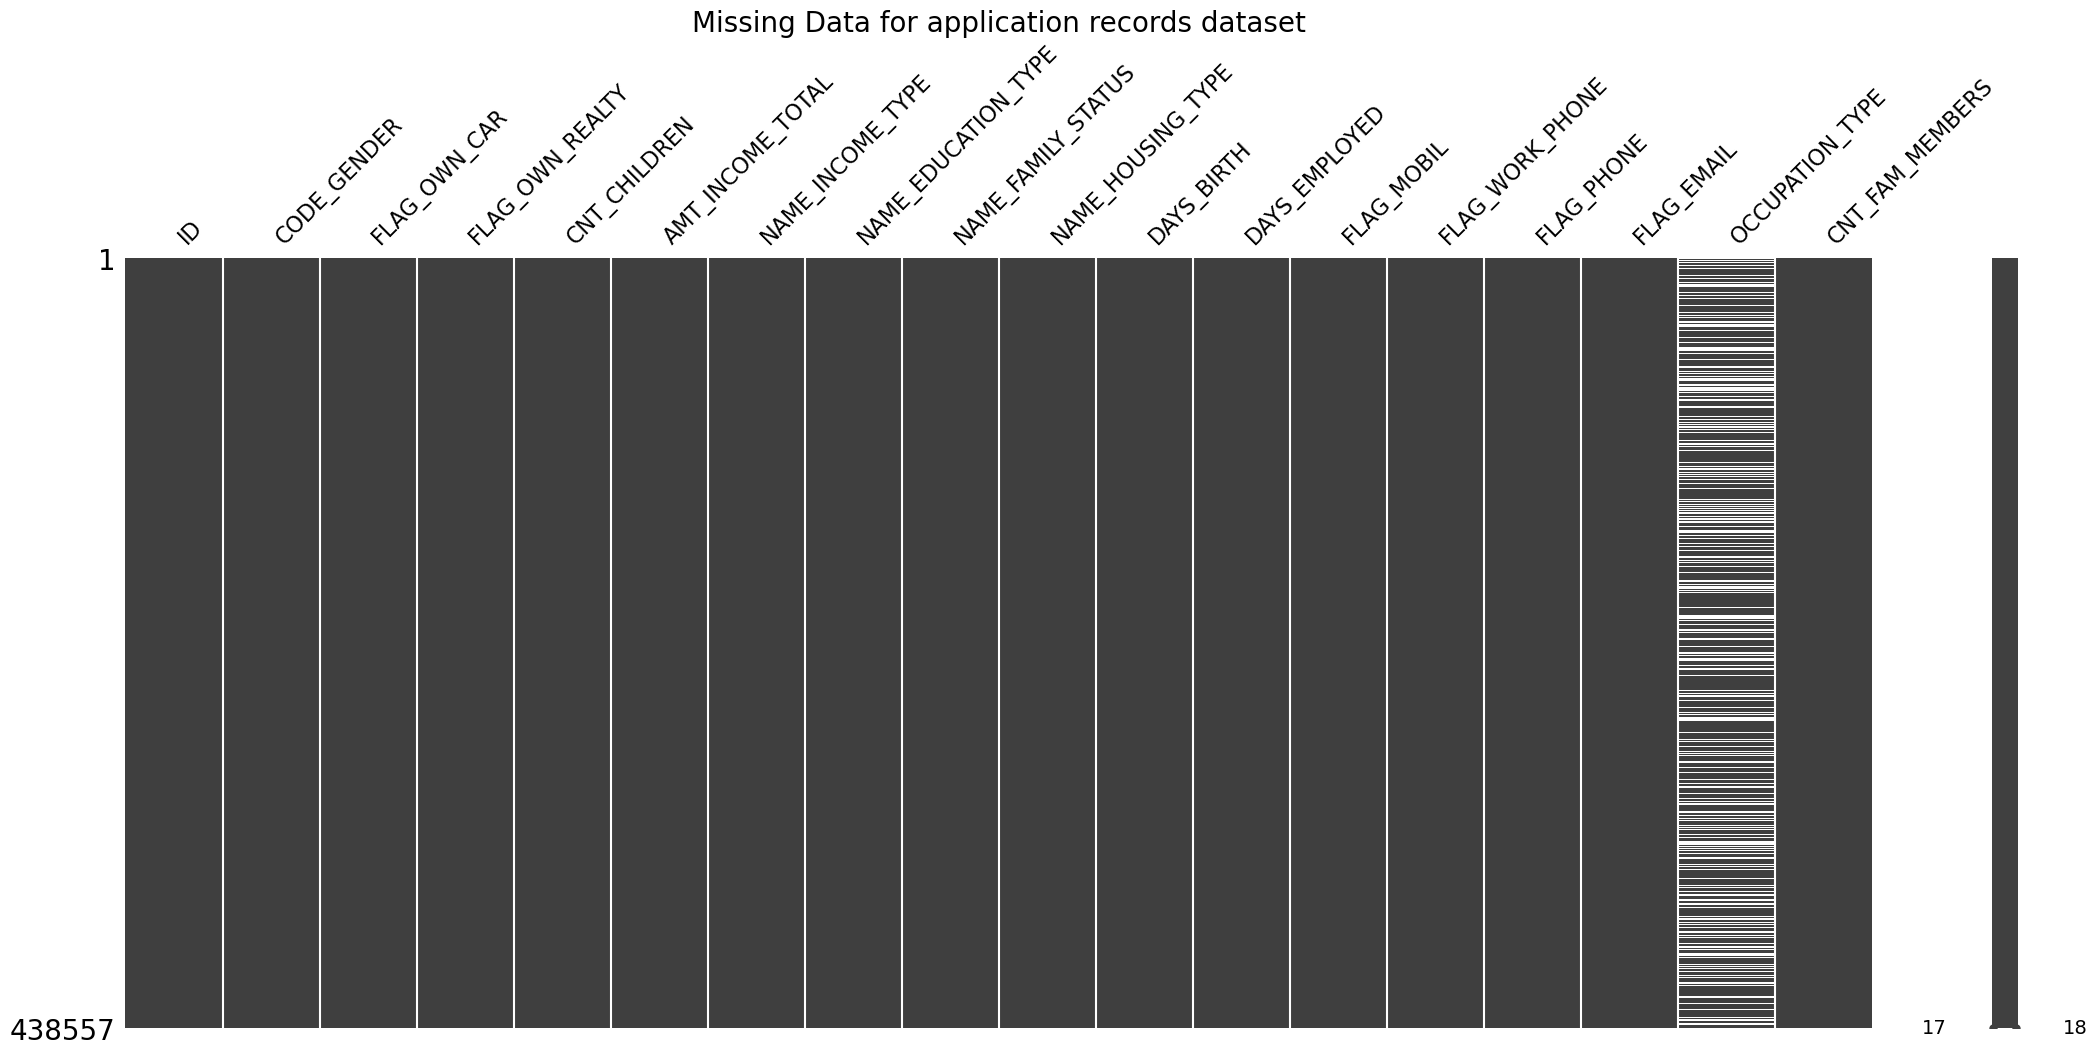

In [7]:
plt_missing_1 = msno.matrix(data)

plt_missing_1.set_title("Missing Data for application records dataset",fontsize=20)

Text(0.5, 1.0, 'Missing Data for credit records dataset')

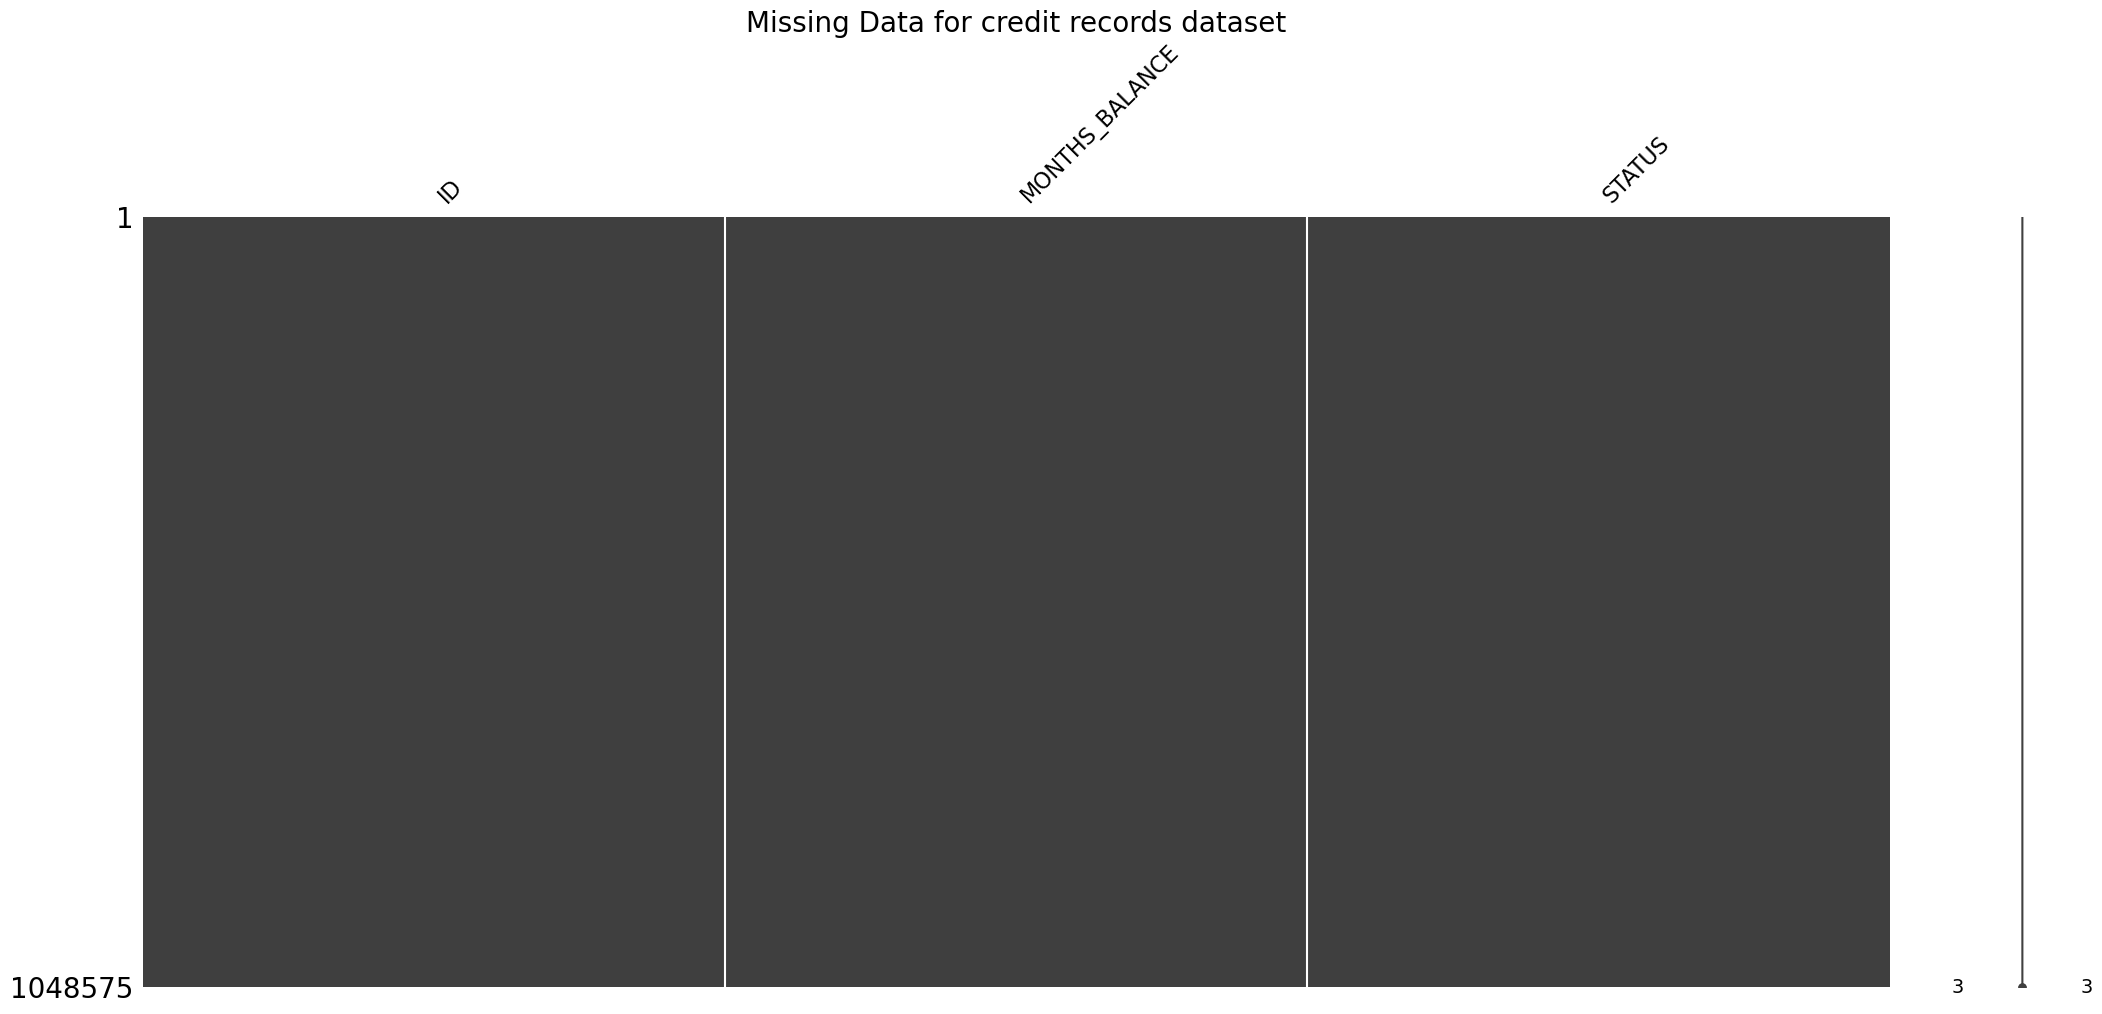

In [8]:
plt_missing_2 = msno.matrix(record)

plt_missing_2.set_title("Missing Data for credit records dataset",fontsize=20)

In [9]:
unique_counts = pd.DataFrame.from_records([(col, data[col].nunique()) for col in data.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Num_Unique
12,FLAG_MOBIL,1
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
15,FLAG_EMAIL,2
14,FLAG_PHONE,2
13,FLAG_WORK_PHONE,2
8,NAME_FAMILY_STATUS,5
6,NAME_INCOME_TYPE,5
7,NAME_EDUCATION_TYPE,5


#### Data Visualization

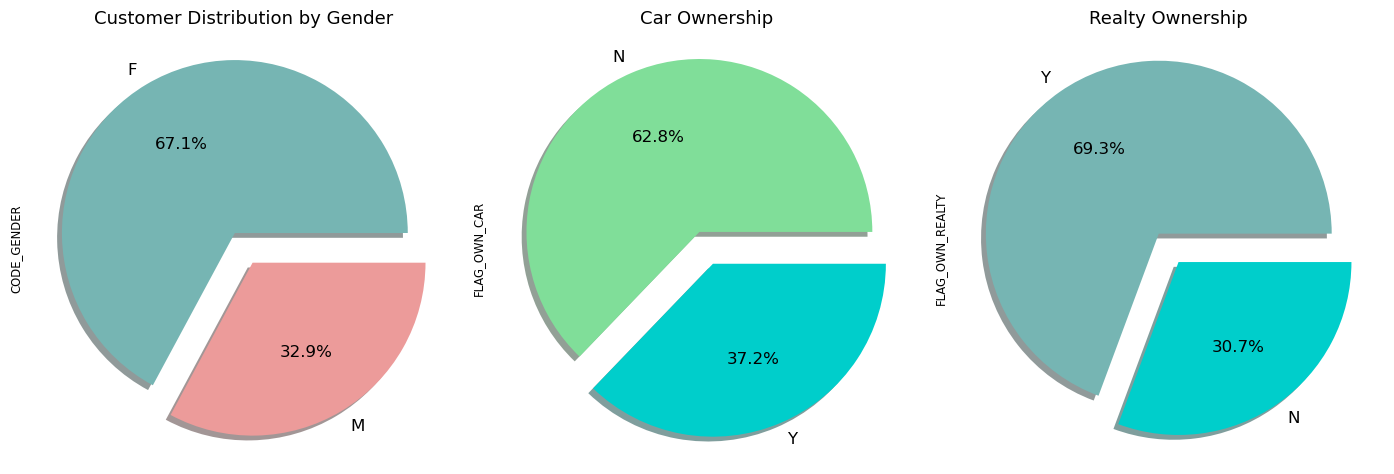

In [13]:
fig, axes = plt.subplots(1,3)

g1= data['CODE_GENDER'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=["#76B5B3","#EC9B9A"],textprops = {'fontsize':12}, ax=axes[0])
g1.set_title("Customer Distribution by Gender")

g2= data['FLAG_OWN_CAR'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#80DE99","#00CECB"],textprops = {'fontsize':12}, ax=axes[1])
g2.set_title("Car Ownership")

g3= data['FLAG_OWN_REALTY'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#76B5B3","#00CECB"],textprops = {'fontsize':12}, ax=axes[2])
g3.set_title("Realty Ownership")

fig.set_size_inches(14,5)

plt.tight_layout()

plt.show()

#### Data Preprocecssing and Feature Engineering

In [14]:
data = data.drop_duplicates('ID', keep='last') #remove duplicate values and keep the last entry of the ID if its repeated.
data.drop('OCCUPATION_TYPE', axis=1, inplace=True) #the occupation type has missing values, we dropped them.

In [15]:
object_columns = data.columns[data.dtypes =='object'].tolist() #object columns in dataset

unique_counts = pd.DataFrame.from_records([(col, data[object_columns][col].nunique()) for col in data[object_columns].columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

unique_counts #unique counts for object columns 

,Column_Name,Num_Unique
0,CODE_GENDER,2
1,FLAG_OWN_CAR,2
2,FLAG_OWN_REALTY,2
3,NAME_INCOME_TYPE,5
4,NAME_EDUCATION_TYPE,5
5,NAME_FAMILY_STATUS,5
6,NAME_HOUSING_TYPE,6


In [16]:
#renaming columns

data.rename(columns={"CODE_GENDER":"Gender","FLAG_OWN_CAR":"Own_Car","FLAG_OWN_REALTY":"Own_Realty",
                     "CNT_CHILDREN":"Children_Count","AMT_INCOME_TOTAL":"Income","NAME_EDUCATION_TYPE":"Education",
                     "NAME_FAMILY_STATUS":"Family_Status","NAME_HOUSING_TYPE":"Housing_Type","DAYS_BIRTH":"Birthday",
                     "DAYS_EMPLOYED":"Employment_Date","FLAG_MOBIL":"Own_Mobile","FLAG_WORK_PHONE":"Own_Work_Phone",
                     "FLAG_PHONE":"Own_Phone","FLAG_EMAIL":"Own_Email","CNT_FAM_MEMBERS":"Family_Member_Count",
                    "NAME_INCOME_TYPE":"Income_Type"},inplace=True)

In [17]:
#all users account open month
open_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
open_month=open_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
customer_data=pd.merge(data,open_month,how="left",on="ID") #merge to record data

#convert categoric features into numeric

customer_data["Gender"] =  customer_data['Gender'].replace(['F','M'],[0,1])
customer_data["Own_Car"] = customer_data["Own_Car"].replace(["Y","N"],[1,0])
customer_data["Own_Realty"] = customer_data["Own_Realty"].replace(["Y","N"],[1,0])
customer_data["Is_Working"] = customer_data["Income_Type"].replace(["Working","Commercial associate","State servant","Pensioner","Student"],[1,1,1,0,0])

customer_data["In_Relationship"] = customer_data["Family_Status"].replace(["Civil marriage","Married","Single / not married",
                                                                          "Separated","Widow"],[1,1,0,0,0])

housing_type = {'House / apartment' : 'House / apartment',
                   'With parents': 'With parents',
                    'Municipal apartment' : 'House / apartment',
                    'Rented apartment': 'House / apartment',
                    'Office apartment': 'House / apartment',
                    'Co-op apartment': 'House / apartment'}

customer_data["Housing_Type"] = customer_data['Housing_Type'].map(housing_type)

family_status = {'Single / not married':'Single',
                     'Separated':'Single',
                     'Widow':'Single',
                     'Civil marriage':'Married',
                    'Married':'Married'}

customer_data["Family_Status"] = customer_data["Family_Status"].map(family_status)

education_type = {'Secondary / secondary special':'secondary',
                     'Lower secondary':'secondary',
                     'Higher education':'Higher education',
                     'Incomplete higher':'Higher education',
                     'Academic degree':'Academic degree'}

customer_data["Education"] = customer_data["Education"].map(education_type)

income_type = {'Commercial associate':'Working',
                  'State servant':'Working',
                  'Working':'Working',
                  'Pensioner':'Pensioner',
                  'Student':'Student'}

customer_data["Income_Type"] = customer_data["Income_Type"].map(income_type)

customer_data["Household_Size"] = customer_data["Children_Count"] + customer_data["In_Relationship"].apply(lambda x: 2 if x==1 else 1)

customer_data["Age"] = round((customer_data.Birthday/365)*-1)

customer_data["Experience"] = customer_data.Employment_Date/365
customer_data['Experience']=customer_data['Experience'].apply(lambda v : int(v*-1) if v <0 else 0)

customer_data=customer_data.drop(columns=['Employment_Date','Birthday','Children_Count'])

customer_data= pd.get_dummies(customer_data, columns=['Income_Type', 'Education','Family_Status',"Housing_Type"])

In [18]:
customer_data.head()

,ID,Gender,Own_Car,Own_Realty,Income,Own_Mobile,Own_Work_Phone,Own_Phone,Own_Email,Family_Member_Count,...,Income_Type_Pensioner,Income_Type_Student,Income_Type_Working,Education_Academic degree,Education_Higher education,Education_secondary,Family_Status_Married,Family_Status_Single,Housing_Type_House / apartment,Housing_Type_With parents
0,5008804,1,1,1,427500.0,1,1,0,0,2.0,...,0,0,1,0,1,0,1,0,1,0
1,5008805,1,1,1,427500.0,1,1,0,0,2.0,...,0,0,1,0,1,0,1,0,1,0
2,5008806,1,1,1,112500.0,1,0,0,0,2.0,...,0,0,1,0,0,1,1,0,1,0
3,5008808,0,0,1,270000.0,1,0,1,1,1.0,...,0,0,1,0,0,1,0,1,1,0
4,5008809,0,0,1,270000.0,1,0,1,1,1.0,...,0,0,1,0,0,1,0,1,1,0


In [20]:
# other_numerical_cols = ["Income","Age","Experience","Household_Size"]

# fig = make_subplots(rows=2, cols=2, start_cell="bottom-left",
#                    subplot_titles=("Income", "Age", "Experience", "Family Member Count"))

# fig.add_trace(go.Box(x=customer_data.Income, name='Income',boxmean=True),row=1,col=1)
# fig.add_trace(go.Box(x=customer_data.Age, name='Age', boxmean=True), row=1, col=2)
# fig.add_trace(go.Box(x=customer_data.Experience, name='Experience', boxmean=True), row=2, col=1)
# fig.add_trace(go.Box(x=customer_data.Household_Size, name="Family Member Count", boxmean=True),row=2, col=2)

# fig.show()

In [21]:
def calculate_z_scores(df, cols):
    for col in cols:
        df[col+"_z_score"] = (df[col] - df[col].mean())/df[col].std()
    return df

df_2 = calculate_z_scores(df = customer_data, cols = ["Income","Experience","Household_Size"])


#removing outliers
filter_2 = df_2.Household_Size_z_score.abs() <= 3.5
filter_3 = df_2.Experience_z_score.abs() <= 3.5
filter_4 = df_2.Income_z_score.abs() <= 3.5

customer_apps = df_2[filter_2 & filter_3 & filter_4]

customer_apps.drop(columns= ["Income_z_score","Experience_z_score","Household_Size_z_score"],inplace=True)

In [22]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

record_count=record.groupby('ID').count()
record_count['dep_value'][record_count['dep_value'] > 0]='Yes' 
record_count['dep_value'][record_count['dep_value'] == 0]='No' 
record_count = record_count[['dep_value']]

In [23]:
# Data frame to analyze length of time since initial approval of credit card
# Shows number of past dues, paid off and no loan status.
grouped = record.groupby('ID')

pivot_tb = record.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min()
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max()
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month']
pivot_tb['window'] += 1 # Adding 1 since month starts at 0.

#Counting number of past dues, paid offs and no loans.
pivot_tb['paid_off'] = pivot_tb[pivot_tb.iloc[:,0:61] == 'C'].count(axis = 1)
pivot_tb['pastdue_1-29'] = pivot_tb[pivot_tb.iloc[:,0:61] == '0'].count(axis = 1)
pivot_tb['pastdue_30-59'] = pivot_tb[pivot_tb.iloc[:,0:61] == '1'].count(axis = 1)
pivot_tb['pastdue_60-89'] = pivot_tb[pivot_tb.iloc[:,0:61] == '2'].count(axis = 1)
pivot_tb['pastdue_90-119'] = pivot_tb[pivot_tb.iloc[:,0:61] == '3'].count(axis = 1)
pivot_tb['pastdue_120-149'] = pivot_tb[pivot_tb.iloc[:,0:61] == '4'].count(axis = 1)
pivot_tb['pastdue_over_150'] = pivot_tb[pivot_tb.iloc[:,0:61] == '5'].count(axis = 1)
pivot_tb['no_loan'] = pivot_tb[pivot_tb.iloc[:,0:61] == 'X'].count(axis = 1)
#Setting Id column to merge with app data.
pivot_tb['ID'] = pivot_tb.index

In [24]:
pivot_tb.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,window,paid_off,pastdue_1-29,pastdue_30-59,pastdue_60-89,pastdue_90-119,pastdue_120-149,pastdue_over_150,no_loan,ID
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,0,3,0,0,0,0,0,1,5001711
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19,9,10,0,0,0,0,0,0,5001712
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22,0,0,0,0,0,0,0,22,5001713
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,0,0,0,0,0,0,0,15,5001714
5001715,NaN,X,X,X,X,X,X,X,X,X,...,60,0,0,0,0,0,0,0,60,5001715


In [25]:
target = pd.DataFrame()
target['ID'] = pivot_tb.index
target['paid_off'] = pivot_tb['paid_off'].values
target['#_of_pastdues'] = pivot_tb['pastdue_1-29'].values+ pivot_tb['pastdue_30-59'].values + pivot_tb['pastdue_60-89'].values +pivot_tb['pastdue_90-119'].values+pivot_tb['pastdue_120-149'].values +pivot_tb['pastdue_over_150'].values
target['no_loan'] = pivot_tb['no_loan'].values
customer_apps_1 = customer_apps.merge(target, how = 'inner', on = 'ID')

customer_apps_2=pd.merge(customer_apps_1,record_count,how='inner',on='ID')
customer_apps_2['target']=customer_apps_2['dep_value']
customer_apps_2.loc[customer_apps_2['target']=='Yes','target']=1
customer_apps_2.loc[customer_apps_2['target']=='No','target']=0

customer_apps_2.drop(columns=["dep_value"],inplace=True)

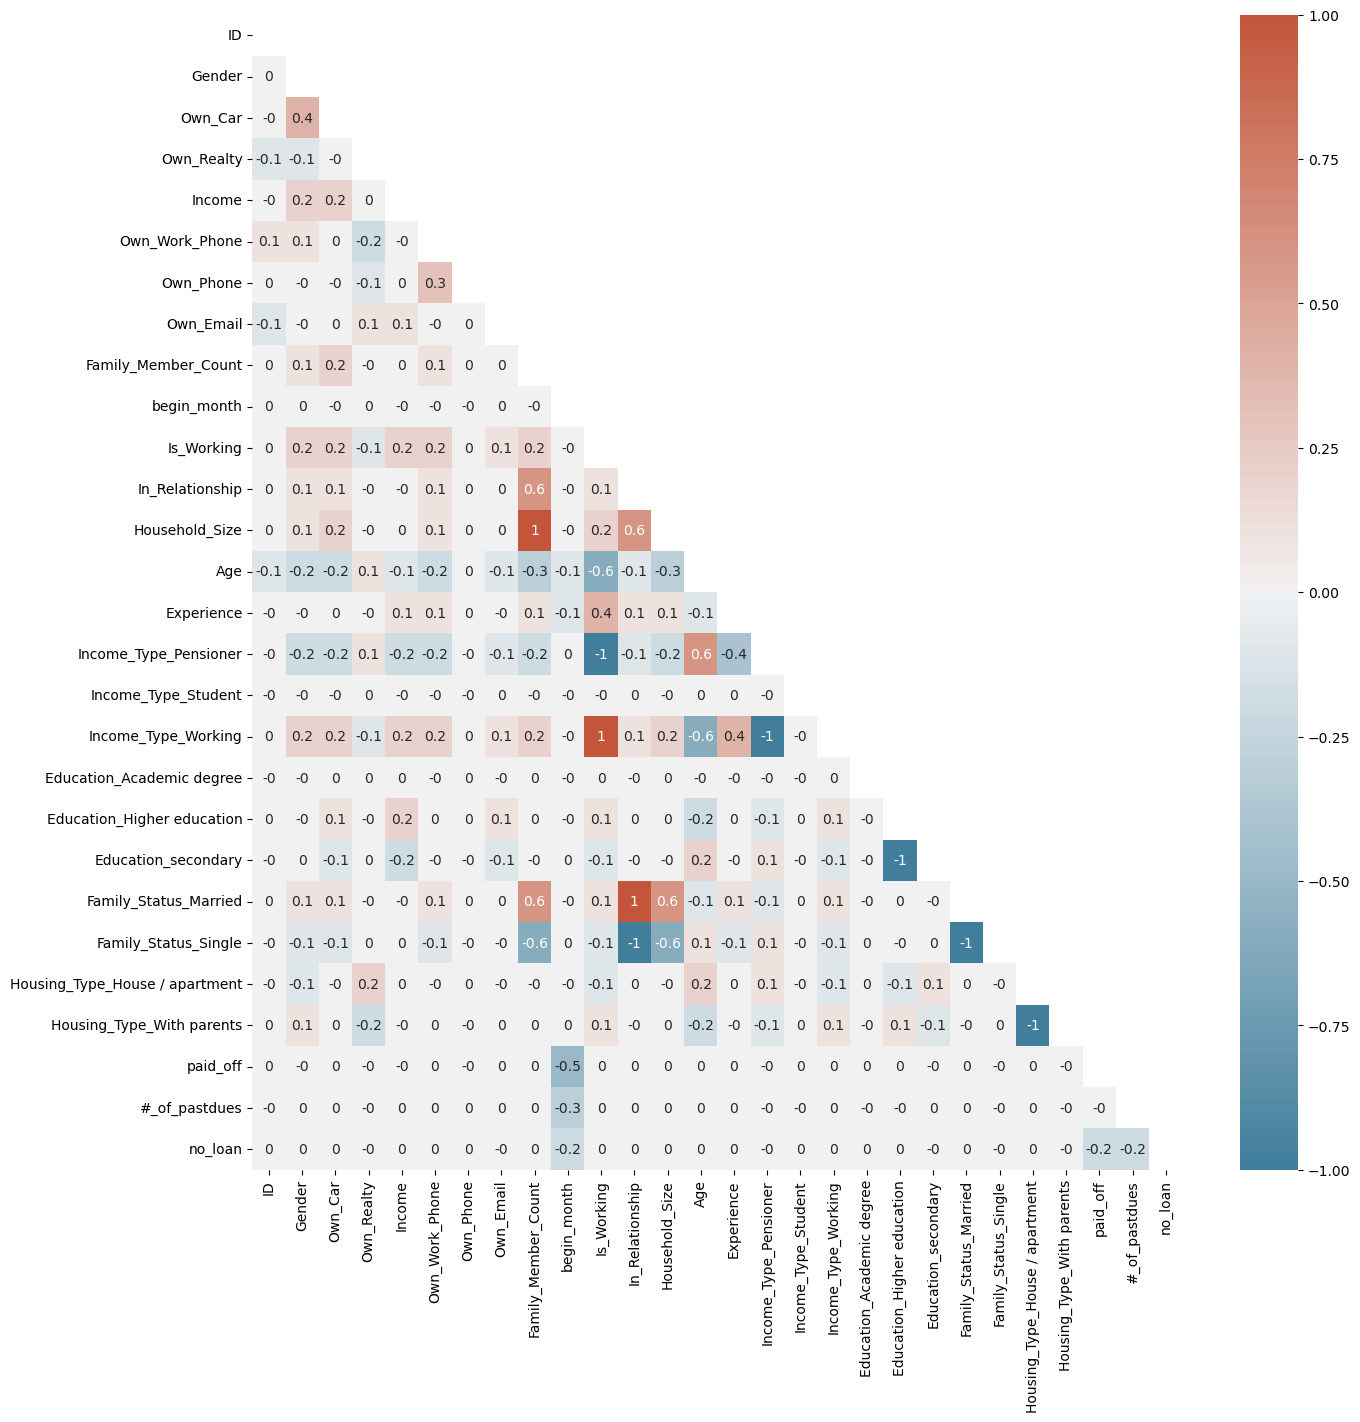

In [29]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = customer_apps_2.drop(columns=["Own_Mobile"]).corr().round(1)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
plt.show()

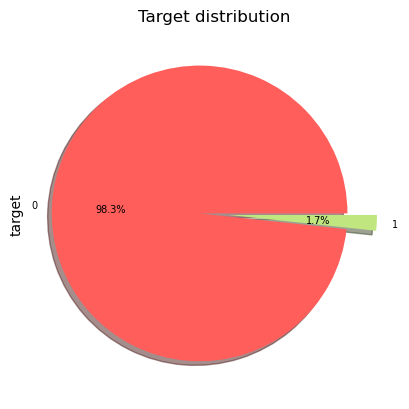

In [30]:
customer_apps_2['target'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=['#FF5E5B', '#C0E680'],textprops = {'fontsize':7}).set_title("Target distribution")

plt.show()

In [31]:
sns.set_context("notebook",font_scale=.7,rc={"grid.linewidth": 0.1,'patch.linewidth': 0.0,
    "axes.grid":True,
    "grid.linestyle": "-",
    "axes.titlesize" : 13,                                       
    'figure.figsize':(15,15)})
                
palette_1 = ['#FF5E5B','#EC9B9A','#00CECB','#80DE99','#C0E680','#FFED66']

sns.set_palette(sns.color_palette(sns.color_palette(palette_1)))

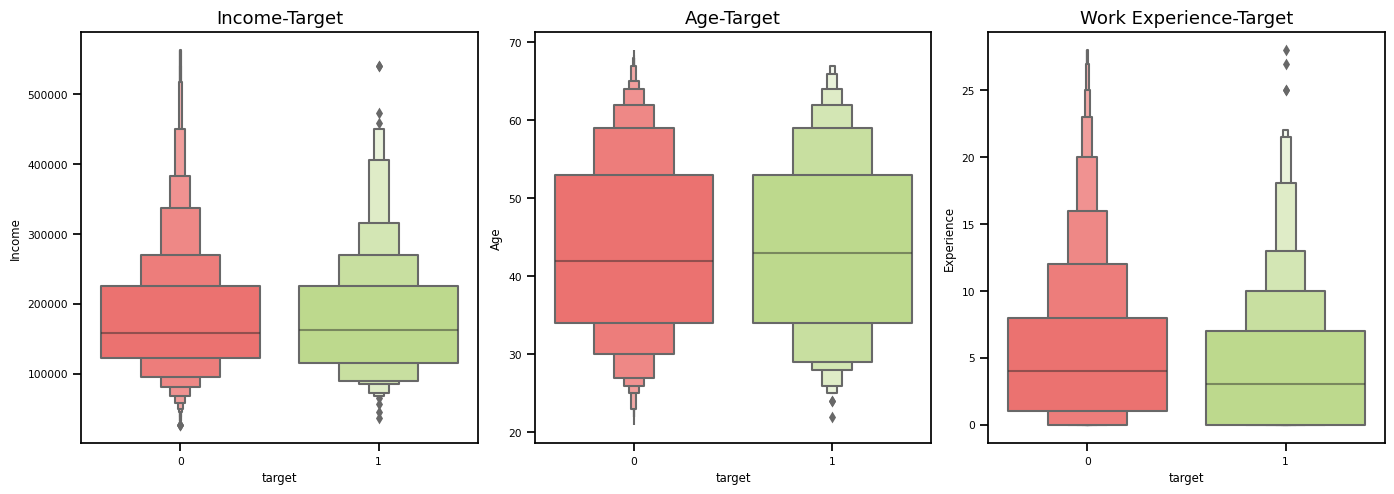

In [34]:
fig, axes = plt.subplots(1,3)

g1=sns.boxenplot(x='target', y='Income', data=customer_apps_2,palette=['#FF5E5B', '#C0E680'], ax=axes[0])
g1.set_title("Income-Target")
g2=sns.boxenplot(x='target', y='Age', data=customer_apps_2,palette=['#FF5E5B', '#C0E680'], ax=axes[1])
g2.set_title("Age-Target")
g3=sns.boxenplot(x='target', y='Experience', data=customer_apps_2,palette=['#FF5E5B', '#C0E680'], ax=axes[2])
g3.set_title("Work Experience-Target")

fig.set_size_inches(14,5)

plt.tight_layout()
plt.show()

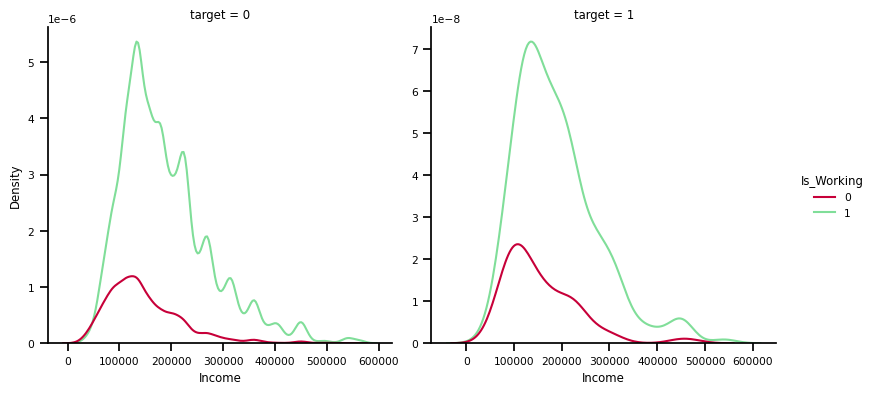

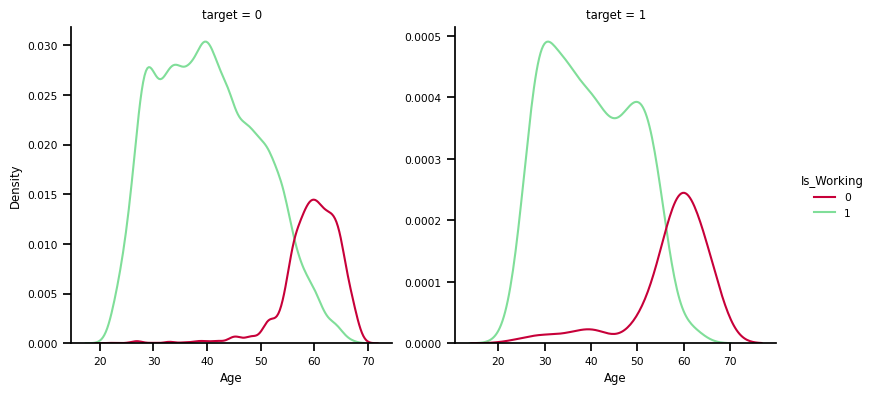

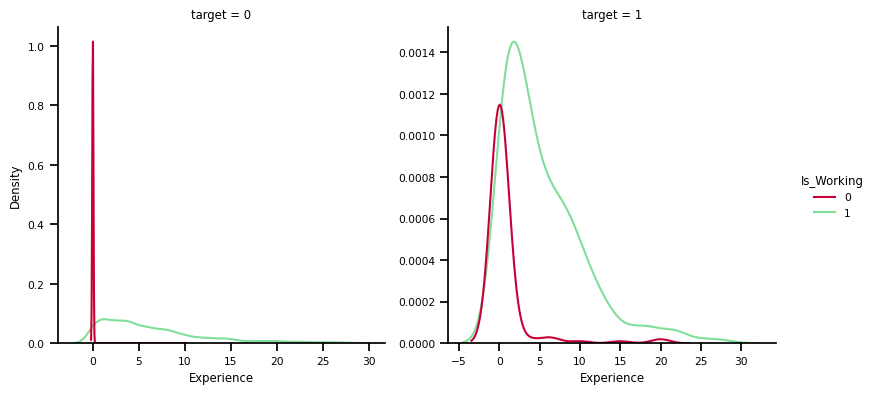

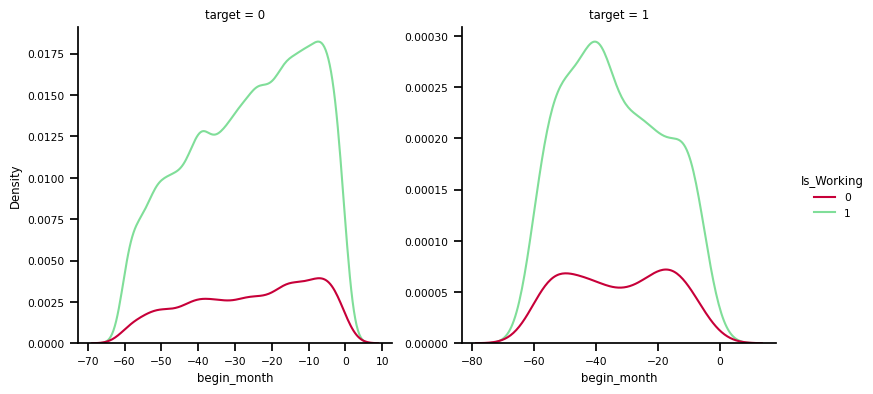

In [37]:
sns.displot(data=customer_apps_2, x='Income', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='Age', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='Experience', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
sns.displot(data=customer_apps_2, x='begin_month', hue="Is_Working", col='target', kind="kde", height=4, facet_kws={'sharey': False, 'sharex': False},palette=['#C70039','#80DE99'])
plt.show()